In [1]:
import json

with open("./output/parsed_article_400_mapped.json", "r") as f:
    articles = json.load(f)

print(len(articles))    

378


In [2]:
relationships_dict = {
    "Supporting Evidence": "Is Evidence For",
    "Methodological Basis": "Is Methodological Basis For",
    "Theoretical Foundation": "Is Theoretical Foundation For", 
    "Data Source": "Is Data Source For",
    "Extension or Continuation": "Is Extension or Continuation Of",
}

In [3]:
articles[1]['grouped_citations']

{'b24': [{'Citation': '(Shang et al., 2015;Serban et al., 2016;Zhang et al., 2020;Roller et al., 2021)',
   'Category': 'Extension or Continuation',
   'Explanation': 'The citing paper builds upon the generation-based and retrieval-based methods proposed by the cited works to further advance the understanding of human-computer conversation.'},
  {'Citation': '(Le et al., 2019)',
   'Category': 'Extension or Continuation',
   'Explanation': 'Le et al. (2019) introduced the who-to-whom (W2W) model for recognizing addressees in multi-party conversations, which is further explored and extended in the citing paper.'},
  {'Citation': 'Le et al. (2019)',
   'Category': 'Methodological Basis',
   'Explanation': 'The cited work introduced a heuristic method for designating the addressee as the preceding speaker, which serves as the basis for the method used in the citing paper.'}],
 'b28': [{'Citation': '(Wu et al., 2017;Zhou et al., 2018;Tao et al., 2019)',
   'Category': 'Methodological Basis

In [4]:
for article_dict in articles:
    citation_dict = {}
    if "grouped_citations" in article_dict.keys():
        for key,val in article_dict['grouped_citations'].items():
            for ref in article_dict["references"]:
                if ref["ref_id"] == key:
                    title = ref["title"]

            title = title.lower()
            if title in citation_dict.keys():
                citation_dict[title] += val
            else:
                citation_dict[title] = val
    article_dict['citations'] = citation_dict

In [5]:
article_dict['citations']

{'an image is worth 16x16 words: transformers for image recognition at scale': [{'Citation': '[4]',
   'Category': 'Methodological Basis',
   'Explanation': 'The cited works introduce the concept of using image transformers as a backbone for video descriptor extraction, which the citing paper adopts for its video copy detection model.'}],
 'swin transformer v2: scaling up capacity and resolution': [{'Citation': '[7]',
   'Category': 'Methodological Basis',
   'Explanation': 'The cited works introduce the concept of using image transformers as a backbone for video descriptor extraction, which the citing paper adopts for its video copy detection model.'}],
 'a simple framework for contrastive learning of visual representations': [{'Citation': '[1]',
   'Category': 'Methodological Basis',
   'Explanation': "The cited work, SimCLR, provides the method of combining with entropy loss for self-supervised learning, which is utilized in the training process of the citing paper's basic model."}]

In [6]:
triplets = []

for article_dict in articles:
    for key, val in article_dict['citations'].items():
        relationships = set()
        for rel in val:
            relationships.add(rel['Category'])
        for r in relationships:
            if r not in relationships_dict.keys():
                relationships_dict[r] = f"Is {r} For"
                
            triplets.append((key, r, article_dict['title'].lower()))
            triplets.append((article_dict['title'].lower(), relationships_dict[r], key))

In [7]:
len(triplets)

25438

In [8]:
import networkx as nx
G = nx.DiGraph()

for subject, predicate, obj in triplets:
    G.add_edge(obj, subject, label=predicate)

/media/s24gb1/90a7e21c-edf4-4782-a0eb-731b73c521c2/Vietnamese_local_LLM_v0/envBE_bu/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32763 (\N{CJK UNIFIED IDEOGRAPH-7FFB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/media/s24gb1/90a7e21c-edf4-4782-a0eb-731b73c521c2/Vietnamese_local_LLM_v0/envBE_bu/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35793 (\N{CJK UNIFIED IDEOGRAPH-8BD1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/media/s24gb1/90a7e21c-edf4-4782-a0eb-731b73c521c2/Vietnamese_local_LLM_v0/envBE_bu/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/media/s24gb1/90a7e21c-edf4-4782-a0eb-731b73c521c2/Vietnamese_local_LLM_v0/envBE_bu/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20027 (\N{CJK UNIFIE

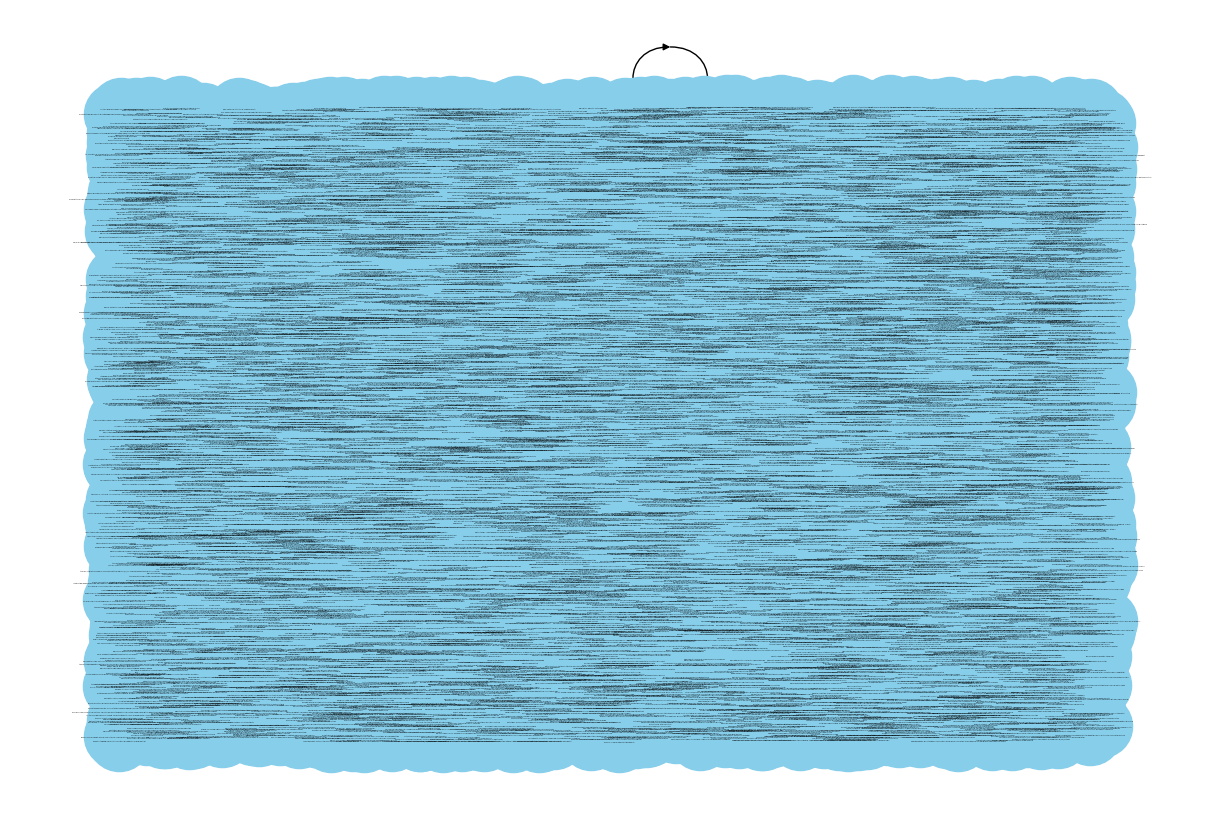

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))


# Position nodes using the spring layout
pos = nx.random_layout(G)  # Increase k for more spread


# Draw the nodes and edges
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=1)

# Draw edge labels
# edge_labels = nx.get_edge_attributes(G, 'label')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=5)

# Show the graph
plt.show()

In [9]:
def find_connected_nodes(graph, node, relationship=None):
    """
    Find nodes connected to the given node with an optional filter on the type of relationship.
    """
    connected_nodes = []
    for n, nbrs in graph.adj.items():
        if n == node:
            for nbr, eattr in nbrs.items():
                if relationship is None or eattr['label'] == relationship:
                    connected_nodes.append(nbr)
    return connected_nodes

def find_shortest_path(graph, source, target):
    """
    Find the shortest path between two nodes.
    """
    try:
        path = nx.shortest_path(graph, source=source, target=target)
        return path
    except nx.NetworkXNoPath:
        return None

# Example Usage
phenaki_related_topics = find_connected_nodes(G, 'cogview: mastering text-to-image generation via transformers')
print("Topics related to cogvideo:", phenaki_related_topics)


Topics related to cogvideo: ['towards accurate image coding: improved autoregressive image generation with dynamic vector quantization']


In [10]:
def find_nodes_by_keyword(graph, keyword):
    """
    Find nodes that contain the given keyword in their name and retrieve their connected nodes and relationships.
    """
    keyword = keyword.lower()  # Convert keyword to lowercase for case-insensitive matching
    matching_nodes = [node for node in graph.nodes if keyword in node.lower()]

    related_nodes = {}
    for node in matching_nodes:
        connections = []
        for neighbor, details in graph[node].items():
            connections.append((neighbor, details['label']))
        related_nodes[node] = connections

    return related_nodes

# Example Usage
keyword = "vq-vae"
phenaki_related = find_nodes_by_keyword(G, keyword)
for node, connections in phenaki_related.items():
    print(f"Node: {node}")
    for conn in connections:
        print(f"  Connected to: {conn[0]} via {conn[1]}")

Node: generating diverse high-fidelity images with vq-vae-2
  Connected to: late-constraint diffusion guidance for controllable image synthesis via Is Methodological Basis For
  Connected to: attributable and scalable opinion summarization via Is Extension or Continuation Of


In [11]:
%pip install pyvis==0.3.1
%pip install network

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from pyvis.network import Network

# Assuming G is your original graph
# Step 1: Create the subgraph for "Node1" and its neighbors
subgraph = nx.ego_graph(G, 'cogview: mastering text-to-image generation via transformers', radius=1, center=True, undirected=False)


nt = Network("500px", "500px", notebook=True)
nt.from_nx(G)

nt.show("nx.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [13]:
keyword = "Evidence"  # Define your filter keyword

filtered_subgraph = nx.DiGraph()  # Initialize an empty directed subgraph
for u, v, data in G.edges(data=True):
    if keyword not in data.get('label', ''):  # Check if the keyword is in the edge label
        filtered_subgraph.add_node(u)  # Add the source node
        filtered_subgraph.add_node(v)  # Add the target node
        filtered_subgraph.add_edge(u, v, label=data['label'])  # Add the edge with the label

nodes_to_remove = [node for node, degree in filtered_subgraph.degree() if degree < 5]
filtered_subgraph.remove_nodes_from(nodes_to_remove)

nt = Network(notebook=True)
nt.from_nx(G)

nt.show("filtered_nx.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [68]:

def find_nodes_by_keyword(graph, keyword):
    """
    Find all nodes that contain the given keyword in their name.
    """
    keyword = keyword.lower()  # Convert keyword to lowercase for case-insensitive matching
    return [node for node in graph.nodes if keyword in node.lower()]

def find_shortest_path_by_keyword(graph, source_keyword, target_keyword):
    """
    Find the shortest path between nodes that contain the source and target keywords in their names.
    """
    source_nodes = find_nodes_by_keyword(graph, source_keyword)
    target_nodes = find_nodes_by_keyword(graph, target_keyword)

    shortest_path = None
    shortest_length = float('inf')

    for source in source_nodes:
        for target in target_nodes:
            try:
                path = nx.shortest_path(graph, source=source, target=target)
                if len(path) < shortest_length:
                    shortest_path = path
                    shortest_length = len(path)
            except nx.NetworkXNoPath:
                continue  # No path exists between this pair of nodes, move to the next pair

    return shortest_path


In [70]:
find_shortest_path_by_keyword(filtered_subgraph, 'vq-vae', 'gan')

In [72]:
def find_relationships(graph, source_keyword, target_keyword):
    """
    Find the relationships (edge labels) between two specific nodes.
    """
    source_nodes = find_nodes_by_keyword(graph, source_keyword)
    target_nodes = find_nodes_by_keyword(graph, target_keyword)

    for source in source_nodes:
        for target in target_nodes:
            if graph.has_edge(source, target):  # Check if there is an edge from source to target
                edge_data = graph.get_edge_data(source, target)
                relationships = [data['label'] for data in edge_data.values()]  # Extract relationship labels
                return relationships
            else:
                return None  # Return None or an empty list if there's no direct connection

# Example Usage
source_node = "Node1"
target_node = "Node2"
relationships = find_relationships(G, source_node, target_node)
print(f"Relationships from {source_node} to {target_node}:", relationships)

Relationships from Node1 to Node2: None


In [73]:
from llama_index.core.query_engine import KnowledgeGraphQueryEngine
from llama_index.core.graph_stores import SimpleGraphStore

# Building Graph Store

In [74]:
import json
import os
from typing import Any, Dict, List, Optional
from dataclasses import dataclass, field
from dataclasses_json import DataClassJsonMixin
from collections import defaultdict

import fsspec
from llama_index.core.graph_stores.types import (
    DEFAULT_PERSIST_DIR,
    DEFAULT_PERSIST_FNAME,
    GraphStore,
)

import fsspec
import logging
logger = logging.getLogger(__name__)


DEFAULT_PERSIST_DIR = "./storage"
DEFAULT_PERSIST_FNAME = "graph_store.json"


class CitationGraphStoreData(DataClassJsonMixin):

    """Simple Graph Store Data container.

    Args:
        graph_dict (Optional[dict]): dict mapping subject to
    """

    graph_dict: Dict[str, List[List[str]]] = defaultdict(list)


    def find_nodes_by_keyword(self, keyword):
        """
        Find all nodes that contain the given keyword in their name.
        """
        keyword = keyword.lower()  # Convert keyword to lowercase for case-insensitive matching
        return [node for node in self.graph_dict.keys() if keyword in node.lower()]


    def get_rel_map(
        self, subjs: Optional[List[str]] = None, depth: int = 2, limit: int = 30
    ) -> Dict[str, List[List[str]]]:
        """Get subjects' rel map in max depth."""
        if subjs is None:
            subjs = list(self.graph_dict.keys())
        rel_map = {}
        for subj in subjs:
            rel_map[subj] = self._get_rel_map(subj, depth=depth, limit=limit)
        # TBD, truncate the rel_map in a spread way, now just truncate based
        # on iteration order
        rel_count = 0
        return_map = {}
        for subj in rel_map:
            if rel_count + len(rel_map[subj]) > limit:
                return_map[subj] = rel_map[subj][: limit - rel_count]
                break
            else:
                return_map[subj] = rel_map[subj]
                rel_count += len(rel_map[subj])
        return return_map

    def _get_rel_map(
        self, keyword: str, depth: int = 2, limit: int = 30
    ) -> List[List[str]]:
        """Get one subect's rel map in max depth."""
        if depth == 0:
            return []
        rel_map = []
        rel_count = 0
        subjs = self.find_nodes_by_keyword(keyword)

        if len(subjs) > 0:
            subj = subjs[0]
            for rel, obj in self.graph_dict[subj]:
                if rel_count >= limit:
                    break
                rel_map.append([subj, rel, obj])
                rel_map += self._get_rel_map(obj, depth=depth - 1)
                rel_count += 1
        return rel_map

In [75]:
class CitationGraphStore(GraphStore):
    """Simple Graph Store.

    In this graph store, triplets are stored within a simple, in-memory dictionary.

    Args:
        simple_graph_store_data_dict (Optional[dict]): data dict
            containing the triplets. See SimpleGraphStoreData
            for more details.
    """

    def __init__(
        self,
        data: Optional[CitationGraphStoreData] = None,
        fs: Optional[fsspec.AbstractFileSystem] = None,
        **kwargs: Any,
    ) -> None:
        """Initialize params."""
        self._data = data or CitationGraphStoreData()
        self._fs = fs or fsspec.filesystem("file")

    @classmethod
    def from_persist_dir(
        cls,
        persist_dir: str = DEFAULT_PERSIST_DIR,
        fs: Optional[fsspec.AbstractFileSystem] = None,
    ) -> "SimpleGraphStore":
        """Load from persist dir."""
        persist_path = os.path.join(persist_dir, DEFAULT_PERSIST_FNAME)
        return cls.from_persist_path(persist_path, fs=fs)

    @property
    def client(self) -> None:
        """Get client.
        Not applicable for this store.
        """
        return

    def get(self, subj: str) -> List[List[str]]:
        """Get triplets."""
        return self._data.graph_dict.get(subj, [])

    def get_rel_map(
        self, subjs: Optional[List[str]] = None, depth: int = 2, limit: int = 30
    ) -> Dict[str, List[List[str]]]:
        """Get depth-aware rel map."""
        return self._data.get_rel_map(subjs=subjs, depth=depth, limit=limit)

    def upsert_triplet(self, subj: str, rel: str, obj: str) -> None:
        """Add triplet."""
        if subj not in self._data.graph_dict:
            self._data.graph_dict[subj] = []
        if (rel, obj) not in self._data.graph_dict[subj]:
            self._data.graph_dict[subj].append([rel, obj])

    def delete(self, subj: str, rel: str, obj: str) -> None:
        """Delete triplet."""
        if subj in self._data.graph_dict:
            if (rel, obj) in self._data.graph_dict[subj]:
                self._data.graph_dict[subj].remove([rel, obj])
                if len(self._data.graph_dict[subj]) == 0:
                    del self._data.graph_dict[subj]

    def persist(
        self,
        persist_path: str = os.path.join(DEFAULT_PERSIST_DIR, DEFAULT_PERSIST_FNAME),
        fs: Optional[fsspec.AbstractFileSystem] = None,
    ) -> None:
        """Persist the SimpleGraphStore to a directory."""
        fs = fs or self._fs
        dirpath = os.path.dirname(persist_path)
        if not fs.exists(dirpath):
            fs.makedirs(dirpath)

        with fs.open(persist_path, "w") as f:
            json.dump(self._data.to_dict(), f)

    def get_schema(self, refresh: bool = False) -> str:
        """Get schema."""
        return "SimpleGraphStore"

    def query(self, query: str, param_map: Optional[Dict[str, Any]] = {}) -> Any:
        response = []
        keywords = [kw.strip() for kw in query.split(",")]
        relmap = self._data.get_rel_map(subjs=keywords, depth=param_map.get("depth") or 1, limit=param_map.get("limit") or 30)
        response.append(relmap)
        return response
    @classmethod
    def from_persist_path(
        cls, persist_path: str, fs: Optional[fsspec.AbstractFileSystem] = None
    ) -> "SimpleGraphStore":
        """Create a SimpleGraphStore from a persist directory."""
        fs = fs or fsspec.filesystem("file")
        if not fs.exists(persist_path):
            logger.warning(
                f"No existing {__name__} found at {persist_path}. "
                "Initializing a new graph_store from scratch. "
            )
            return cls()

        logger.debug(f"Loading {__name__} from {persist_path}.")
        with fs.open(persist_path, "rb") as f:
            data_dict = json.load(f)
            data = CitationGraphStoreData.from_dict(data_dict)
        return cls(data)

    @classmethod
    def from_dict(cls, save_dict: dict) -> "SimpleGraphStore":
        data = CitationGraphStoreData.from_dict(save_dict)
        return cls(data)

    def to_dict(self) -> dict:
        return self._data.to_dict()

In [76]:
citation_graph_store = CitationGraphStore()
for triplet in triplets:
    citation_graph_store.upsert_triplet(triplet[0], triplet[1], triplet[2])

In [80]:
from llama_index.core import StorageContext, Settings
from llama_index.llms.ollama import Ollama
from llama_index.llms.openai import OpenAI

storage_context = StorageContext.from_defaults(graph_store=citation_graph_store)
llm = OpenAI(model="gpt-3.5-turbo", api_key="")
Settings.llm = llm

In [87]:
from llama_index.core.query_engine import KnowledgeGraphQueryEngine
from llama_index.core import PromptTemplate
from llama_index.core.prompts.prompt_type import PromptType


QUERY_KEYWORD_EXTRACT_TEMPLATE_TMPL = (
    "A question is provided below. Given the question, extract up to 1 keywords related to a paper or a method"
    "keywords from the text. Focus on extracting the keywords that we can use "
    "to best lookup answers to the question. Avoid stopwords, word like 'papers', 'data source'.\n"
    "---------------------\n"
    "{query_str}\n"
    "---------------------\n"
    "Provide keywords in the following comma-separated format, no quotation mark: <keywords>\n"
)

QUERY_KEYWORD_EXTRACT_TEMPLATE = PromptTemplate(
    QUERY_KEYWORD_EXTRACT_TEMPLATE_TMPL,
    prompt_type=PromptType.QUERY_KEYWORD_EXTRACT,
)

query_engine = KnowledgeGraphQueryEngine(storage_context=storage_context,
                                          graph_query_synthesis_prompt=QUERY_KEYWORD_EXTRACT_TEMPLATE, verbose=True)

In [89]:
print(query_engine.query("what are the continuation works of vq-vae?"))

Graph Store Query:
continuation, vq-vae
Graph Store Response:
[{'continuation': [], 'vq-vae': [['generating diverse high-fidelity images with vq-vae-2', 'Methodological Basis', 'late-constraint diffusion guidance for controllable image synthesis'], ['generating diverse high-fidelity images with vq-vae-2', 'Extension or Continuation', 'attributable and scalable opinion summarization']]}]
Final Response: The continuation works of VQ-VAE include "late-constraint diffusion guidance for controllable image synthesis" and "attributable and scalable opinion summarization."
The continuation works of VQ-VAE include "late-constraint diffusion guidance for controllable image synthesis" and "attributable and scalable opinion summarization."
